### Speech predictor model - who's most likely to have spoken a certain line?

<img src="https://forbes.hu/wp-content/uploads/2021/08/southpark2_forbes.jpg" width="1000"/>


In [1]:
import sys 
sys.path.append('../../')
from src.import_packages import *

Importing the following packages: pandas, numpy, matplotlib, seaborn, plotly, warnings


In [123]:
data = pd.read_csv('data/transcript_cleaned.csv')
data = data[data['speaker'].isin(['Cartman', 'Kyle', 'Stan', 'Kenny'])]
data.head(3)

,speaker,line,season,episode_num,episode_title,speaking_to,line_clean
1,Kyle,"Ah, damn it! My little brother's trying to fol...",1,1,Cartman Gets an Anal Probe,Other,ah damn little brother trying follow school
3,Kyle,"Ike, you can't come to school with me. [Ike Ch...",1,1,Cartman Gets an Anal Probe,Cartman,ike school
4,Cartman,"Yeah, go home you little dildo!",1,1,Cartman Gets an Anal Probe,Kyle,home little dildo


In [124]:
data['speaker'].value_counts()

Cartman    10761
Stan        7491
Kyle        7176
Kenny        826
Name: speaker, dtype: int64

### Preprocessing text
- No need to remove stopwords
- Lemmatize
- Lowercase
- No special characters
- No numbers

In [125]:
import re
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

cList = {
    "ain't": "am not",    "aren't": "are not",    "can't've": "cannot have",    "can't": "cannot",    "'cause": "because",    "could've": "could have",    "couldn't've": "could not have",
    "couldn't": "could not",    "didn't": "did not",    "doesn't": "does not",    "don't": "do not",    "hadn't've": "had not have",    "hadn't": "had not",        "hasn't": "has not",
    "haven't": "have not",    "he'd've": "he would have",    "he'd": "he would",      "he'll've": "he will have",    "he'll": "he will",        "he's": "he is",    "how'd'y": "how do you",
    "how'd": "how did",      "how'll": "how will",    "how's": "how is",    "i'd've": "i would have",    "i'd": "i would",    "i'll've": "i will have",    "i'll": "i will",    
    "i'm": "i am",    "i've": "i have",    "isn't": "is not",    "it'd've": "it would have",    "it'd": "it would",    "it'll've": "it will have",      "it'll": "it will",      "it's": "it is",
    "let's": "let us",    "ma'am": "madam",    "mayn't": "may not",    "might've": "might have",    "mightn't've": "might not have",    "mightn't": "might not",        "must've": "must have",
    "mustn't've": "must not have",    "mustn't": "must not",    "needn't've": "need not have",      "needn't": "need not",      "oughtn't've": "ought not have",    "oughtn't": "ought not",
    "shan't've": "shall not have",    "shan't": "shall not",    "sha'n't": "shall not",    "she'd've": "she would have",    "she'd": "she would",    "she'll've": "she will have",
    "she'll": "she will",      "she's": "she is",    "should've": "should have",    "shouldn't've": "should not have",    "shouldn't": "should not",      "so've": "so have",
    "so's": "so is",    "that'd've": "that would have",    "that'd": "that would",      "that's": "that is",    "there'd've": "there would have",    "there'd": "there had",  
    "there's": "there is",    "they'd've": "they would have",    "they'd": "they would",    "they'll've": "they will have",    "they'll": "they will",      "they're": "they are",
    "they've": "they have",    "to've": "to have",    "wasn't": "was not",    "we'd've": "we would have",    "we'd": "we would",    "we'll've": "we will have",      "we'll": "we will",  
    "we're": "we are",    "we've": "we have",    "weren't": "were not",    "what'll've": "what will have",    "what'll": "what will",        "what're": "what are",    "what's": "what is",
    "what've": "what have",    "when's": "when is",    "when've": "when have",    "where'd": "where did",    "where's": "where is",    "where've": "where have",    "who'll've": "who will have",
    "who'll": "who will",        "who's": "who is",    "who've": "who have",    "why's": "why is",    "why've": "why have",    "will've": "will have",    "won't've": "will not have",
    "won't": "will not",        "would've": "would have",    "wouldn't've": "would not have",    "wouldn't": "would not",    "y'all'd've": "you all would have",    "y'all'd": "you all would",
    "y'all're": "you all are",    "y'all've": "you all have",    "y'all": "you all",    "y'alls": "you all",      "you'd've": "you would have",    "you'd": "you had",
    "you'll've": "you will have",    "you'll": "you will",      "you're": "you are",    "you've": "you have" }

def decontracted(phrase):
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def text_cleaner(text, treat_contractions = True, lemmatize = True):  
    
    # lower chars and treat whitespaces
    text = text.lower()
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces  

    # delete narration part between [ and ]
    text = re.sub("[\[].*?[\]]", "", text)

    # contractions
    if treat_contractions:
        text = decontracted(text)
        text = ' '.join([cList.get(word,word) for word in text.split()])

    # delete special characters and numbers
    text = re.compile('[^a-z]').sub(' ', text) 

    # after numbers
    text = re.sub(' th ', '', text)
    text = re.sub(' st ', '', text)
    text = re.sub(' nd ', '', text)
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces 

    # lemmatize   
    if lemmatize:
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    # final whitespace treatment
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces     

    return text

In [126]:
data['line_clean'] = data['line'].apply(lambda x: text_cleaner(x))
data.drop(['season', 'episode_num', 'episode_title', 'speaking_to', 'line'], 1, inplace = True)

In [127]:
data.head()

,speaker,line_clean
1,Kyle,ah damn it my little brother is trying to foll...
3,Kyle,ike you can not come to school with me
4,Cartman,yeah go home you little dildo
5,Kyle,dude do not call my brother a dildo
6,Stan,what is a dildo


## 1st model: tf-df vectorizer

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from lightgbm import LGBMClassifier

In [129]:
X = data['line_clean'].copy()
y = data['speaker'].copy()

X_tr, X_valid, y_tr, y_valid = train_test_split(X, y, train_size=0.75, random_state = 91)

In [130]:
vectorizer = TfidfVectorizer(min_df = 5)
vectorizer.fit(X_tr)
print(len(vectorizer.vocabulary_))

2615


In [131]:
X_train_vectorized = vectorizer.transform(X_tr).toarray()
X_valid_vectorized = vectorizer.transform(X_valid).toarray()

Reduce dimensionality by PCA

In [132]:
pca = PCA(random_state=91, n_components = 25)
pca.fit(X_train_vectorized)

PCA(n_components=25, random_state=91)

In [133]:
sum(pca.explained_variance_ratio_)

0.17475061113608098

Won't use PCA - very small variance is being captured

Apply LightGBM Classifier

In [137]:
%%time

lgb = LGBMClassifier(n_jobs=-1, objective='multiclass', random_state=91, n_estimators = 100)
lgb.fit(X_train_vectorized, y_tr, eval_set = (X_valid_vectorized, y_valid), verbose = 0)

Wall time: 20.1 s


LGBMClassifier(objective='multiclass', random_state=91)

Evaluate on test set

In [138]:
predictions = lgb.predict(X_valid_vectorized)
print(classification_report(y_valid, predictions, digits = 4))

              precision    recall  f1-score   support

     Cartman     0.5514    0.7930    0.6505      2720
       Kenny     0.4444    0.0800    0.1356       200
        Kyle     0.4821    0.3073    0.3753      1793
        Stan     0.4440    0.3533    0.3935      1851

    accuracy                         0.5146      6564
   macro avg     0.4805    0.3834    0.3887      6564
weighted avg     0.4989    0.5146    0.4872      6564



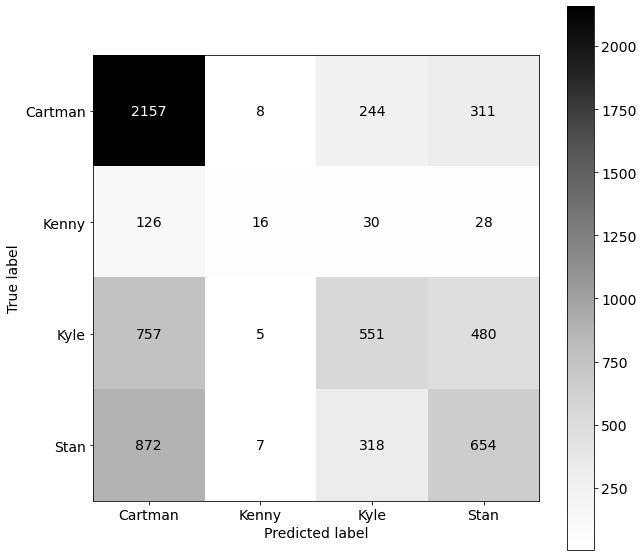

In [139]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(lgb, X_valid_vectorized, y_valid, ax = ax, cmap = 'Greys')
plt.show()

The simple tf-idf vectorization (with some regularization) achieves a ~50% accuracy. Easiest to predict is Cartman, most difficult is Kenny

## 2nd model: Google's Universal Sentence Encoder

In [140]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [142]:
import os
os.environ['TFHUB_CACHE_DIR'] = '../southpark/data/cache'

module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
model = hub.load(module_url)

#model.predict(tf.convert_to_tensor(['I am', "I'm"]))

In [158]:
%%time

X_tr_USE = np.array(model(X_tr.values))
X_valid_USE = np.array(model(X_valid.values))

Wall time: 13.7 s


Apply LGBM

In [164]:
%%time

lgb = LGBMClassifier(n_jobs=-1, objective='multiclass', random_state=91, n_estimators = 250)
lgb.fit(X_tr_USE, y_tr, eval_set = (X_valid_USE, y_valid), verbose = 0)

Wall time: 3min 10s


LGBMClassifier(n_estimators=250, objective='multiclass', random_state=91)

Evaluate

In [165]:
predictions = lgb.predict(X_valid_USE)
print(classification_report(y_valid, predictions, digits = 4))

              precision    recall  f1-score   support

     Cartman     0.5742    0.7599    0.6541      2720
       Kenny     0.3333    0.0850    0.1355       200
        Kyle     0.4402    0.3491    0.3894      1793
        Stan     0.4359    0.3512    0.3890      1851

    accuracy                         0.5119      6564
   macro avg     0.4459    0.3863    0.3920      6564
weighted avg     0.4913    0.5119    0.4912      6564



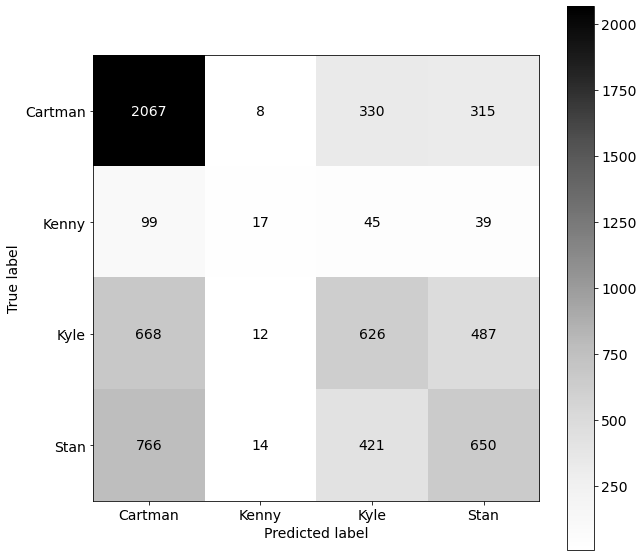

In [166]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(lgb, X_valid_USE, y_valid, ax = ax, cmap = 'Greys')
plt.show()

Try some sentences

In [192]:
def predict_text_with_USE(input = 'Oh my God, they killed Kenny!'):

    input_cleaned = text_cleaner(input)
    input_encoded = np.array(model([input_cleaned]))
    input_prediction = lgb.predict_proba(input_encoded)

    result = pd.concat([pd.Series(lgb.classes_), 
                        pd.Series(input_prediction[0])], 1)\
                .rename(columns = {0 : '', 1 : '%'})\
                .sort_values('%', ascending = False)\
                .reset_index(drop = True)

    print('Probabilities of saying the sentence <', input, '>')

    return result

In [193]:
predict_text_with_USE()

Probabilities of saying the sentence < Oh my God, they killed Kenny! >


,,%
0,Stan,0.847816
1,Kyle,0.089982
2,Cartman,0.060954
3,Kenny,0.001248


In [196]:
predict_text_with_USE('You bastards!')

Probabilities of saying the sentence < You bastards! >


,,%
0,Kyle,0.909080
1,Stan,0.038888
2,Kenny,0.029061
3,Cartman,0.022972


In [203]:
predict_text_with_USE('You stupid jew!')

Probabilities of saying the sentence < You stupid jew! >


,,%
0,Cartman,0.639282
1,Kyle,0.268074
2,Stan,0.091025
3,Kenny,0.001619


In [207]:
predict_text_with_USE("Don't call me that fatso!")

Probabilities of saying the sentence < Don't call me that fatso! >


,,%
0,Kyle,0.459373
1,Cartman,0.281830
2,Stan,0.257070
3,Kenny,0.001727


In [231]:
predict_text_with_USE("Momma")

Probabilities of saying the sentence < Momma >


,,%
0,Cartman,0.569875
1,Stan,0.258105
2,Kyle,0.164518
3,Kenny,0.007501


## 3rd model: word embeddings aggregated to sentence embeddings

Hold off this for now - if sentence encoder didn't perform significantly better, maybe this won't either. Maybe try a neural net (RNN, LSTM) approach with embeddings in an Embedding() layer